In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score

In [2]:
EPOCHS = 5
BATCH_SIZE = 16
LEARNING_RATE = 3e-4
KERNEL_DIM = 3
POOL_DIM = 2

In [26]:
X_train = pd.read_csv("data/train_data.csv").drop(['Unnamed: 0', 'Y'], axis=1)
y_train = pd.read_csv("data/train_data.csv")['Y']

X_test = pd.read_csv("data/test_data.csv").drop(['Unnamed: 0', 'Y'], axis=1)
y_test = pd.read_csv("data/test_data.csv")['Y']

In [4]:
X_train = torch.tensor(X_train.to_numpy()).view((-1, 28, 28))
y_train = torch.tensor(y_train.values)
X_test = torch.tensor(X_test.to_numpy()).view((-1, 28, 28))
y_test = torch.tensor(y_test.values)

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 28, 28]),
 torch.Size([10000]))

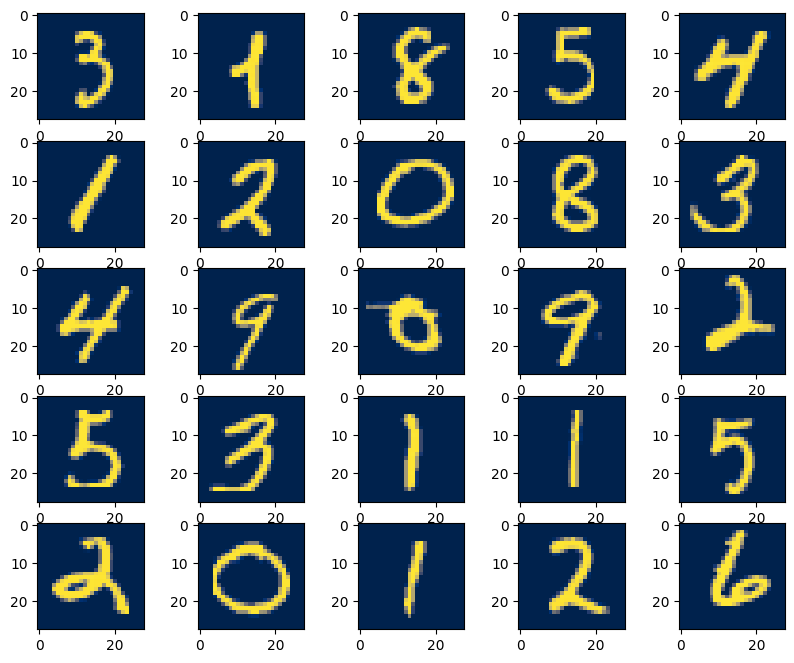

In [6]:
plt.figure(figsize=(10, 8))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    idx = torch.randint(X_train.shape[0], (1,)).item()
    plt.imshow(X_train[idx], cmap='cividis')


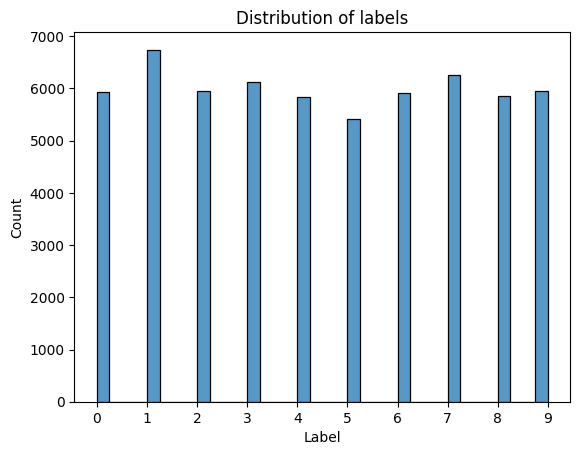

In [14]:
sns.histplot(y_train)
plt.xticks(torch.arange(0, len(set(y_train.detach().numpy())), 1))
plt.title("Distribution of labels")
plt.ylabel("Count")
plt.xlabel("Label");

In [15]:
X_train = torch.tensor(X_train) / 255
X_test = torch.tensor(X_test) / 255
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)   

C:\Users\adika\AppData\Local\Temp\ipykernel_76484\2818170604.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train) / 255
C:\Users\adika\AppData\Local\Temp\ipykernel_76484\2818170604.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test) / 255
C:\Users\adika\AppData\Local\Temp\ipykernel_76484\2818170604.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train)
C:\Users\adika\AppData\Local\Temp\ipykernel_76484\2818170604.py:4: UserWarning: To copy construct f

In [16]:
class MNISTData(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        return (self.x[i], self.y[i])

In [17]:
train_data = DataLoader(MNISTData(X_train, y_train), BATCH_SIZE, shuffle=True)
test_data = DataLoader(MNISTData(X_test, y_test), BATCH_SIZE, shuffle=True)

In [19]:
class Conv2dLayer(nn.Module):
    def __init__(self, in_dim, kernel_size):
        super().__init__()
        self.in_dim = in_dim
        self.kernel_size = kernel_size
        self.kernel = nn.Linear(kernel_size[0], kernel_size[0])

    def forward(self, x):
        x = x.unsqueeze(1)
        output_size = x.shape[-1] - self.kernel_size[0] + 1
        windows = F.unfold(x, x.shape[-1] - self.kernel_size[0] + 1)
        windows = windows.view((windows.shape[0], windows.shape[1], self.kernel_size[0], self.kernel_size[0]))

        convs = self.kernel(windows).sum(dim=-1).sum(dim=-1)
        output = convs.view((convs.shape[0], output_size, output_size))

        return output


class AvgPool2dLayer(nn.Module):
    def __init__(self, pool_size):
        super().__init__()
        self.kernel_size = pool_size

    def forward(self, x):
        x = x.unsqueeze(1)
        window_size = x.shape[-1] - self.kernel_size[0] + 1

        windows = F.unfold(x, kernel_size=window_size).mean(dim=-1)
        output = windows.view((x.shape[0], window_size, window_size))[:, ::self.kernel_size[0], ::self.kernel_size[1]]
        
        return output


class CNN(nn.Module):
    def __init__(self, in_dim, conv1_kernel_size, conv_pool_size):
        super().__init__()
        self.conv1 = Conv2dLayer(in_dim, (conv1_kernel_size, conv1_kernel_size))
        self.pool  = AvgPool2dLayer((conv_pool_size, conv_pool_size))
        self.conv2 = Conv2dLayer(in_dim, (conv1_kernel_size, conv1_kernel_size))
        self.lin   = nn.Linear(25, 10)

    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.pool(out1)
        out3 = self.conv2(out2)
        out4 = self.pool(out3)
        out5 = out4.flatten(1)
        output = self.lin(out5)
        return output

In [20]:
model = CNN(1, KERNEL_DIM, POOL_DIM)
optim = torch.optim.AdamW(model.parameters(), LEARNING_RATE)

In [21]:
dummy_data = torch.randn((16, 28, 28))
model(dummy_data).shape

torch.Size([16, 10])

In [22]:
def train_epoch():
    lossi = []
    c = 0
    for x, y in train_data:
        output = model(x)
        loss = F.cross_entropy(output, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        lossi.append(loss.item())
        c += 1

    return torch.tensor(lossi).mean().item()


@torch.no_grad
def val_epoch():
    lossi = []
    for x, y in test_data:
        output = model(x)
        loss = F.cross_entropy(output, y)
        lossi.append(loss.item())

    return torch.tensor(lossi).mean().item()

In [23]:
train_lossi, val_lossi = [], []
for epoch in range(EPOCHS):
    train_loss = train_epoch()
    val_loss = val_epoch()

    train_lossi.append(train_loss)
    val_lossi.append(val_loss)

    print(f"EPOCH: {epoch} |  TRAIN-LOSS: {train_loss} |  VAL-LOSS: {val_loss}")

EPOCH: 0 |  TRAIN-LOSS: 1.0799587965011597 |  VAL-LOSS: 0.6126217246055603
EPOCH: 1 |  TRAIN-LOSS: 0.5880499482154846 |  VAL-LOSS: 0.5209958553314209
EPOCH: 2 |  TRAIN-LOSS: 0.526253879070282 |  VAL-LOSS: 0.49135467410087585
EPOCH: 3 |  TRAIN-LOSS: 0.49823203682899475 |  VAL-LOSS: 0.46600142121315
EPOCH: 4 |  TRAIN-LOSS: 0.4809541702270508 |  VAL-LOSS: 0.4522533714771271


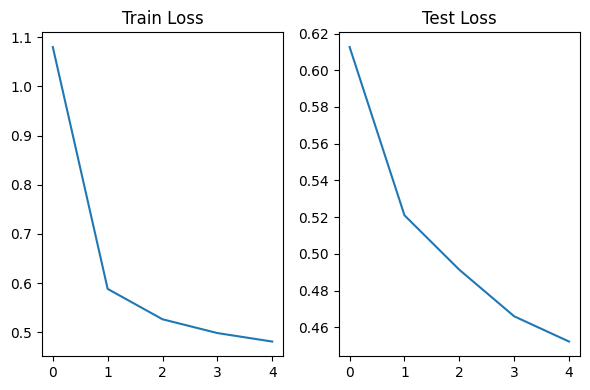

In [24]:
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
plt.title("Train Loss")
plt.plot(train_lossi)
plt.subplot(1, 2, 2)
plt.title("Test Loss")
plt.plot(val_lossi)
plt.tight_layout()

In [25]:
acc = []
for x,y in train_data:
    cur_pred = model(x).argmax(dim=1)
    acc.append(accuracy_score(cur_pred, y))

print(f"Train Accuracy: {torch.tensor(acc).mean() * 100}%")


acc = []
for x,y in test_data:
    cur_pred = model(x).argmax(dim=1)
    acc.append(accuracy_score(cur_pred, y))

print(f"Test Accuracy: {torch.tensor(acc).mean() * 100}%")

Train Accuracy: 86.06166666666667%
Test Accuracy: 86.92999999999999%
